# Pelatihan, Tuning, dan Evaluasi Model

In [1]:
import os
import sys
import cv2
import joblib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from skimage.feature import hog, local_binary_pattern

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from src.configs.config import (
    DATA_RAW_PATH, RESULTS_PATH, SAVED_MODEL_PATH, CLASSES, IMAGE_SIZE,
    HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK, 
    TEST_SIZE, RANDOM_STATE
)
from src.utils.logger import logger
from src.utils.dataset_loader import load_images_from_folder
from src.utils.metrics import evaluate_model, plot_confusion_matrix
from src.utils.roc_curve import plot_roc_curve
from src.utils.precision_recall import plot_precision_recall_curve
from src.utils.prediction_examples import plot_prediction_examples

## Contained Code

In [2]:
def augment_image(image):
    augmented_images = [image]
    augmented_images.append(cv2.flip(image, 1))
    augmented_images.append(np.clip(image * 1.2, 0, 255).astype(np.uint8))
    augmented_images.append(np.clip(image * 0.8, 0, 255).astype(np.uint8))
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    angle = random.uniform(-15, 15)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    augmented_images.append(cv2.warpAffine(image, M, (w, h)))
    return augmented_images

def resize_image(image):
    return cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def normalize_image(image):
    return image.astype('float32') / 255.0

def preprocess_image_for_feature_extraction(image):
    resized_color_uint8 = resize_image(image)
    gray_image = to_grayscale(resized_color_uint8)
    normalized_gray = normalize_image(gray_image)
    normalized_color = normalize_image(resized_color_uint8)
    return normalized_gray, normalized_color

def extract_hog_features(gray_image):
    return hog(gray_image, orientations=HOG_ORIENTATIONS, pixels_per_cell=HOG_PIXELS_PER_CELL,
               cells_per_block=HOG_CELLS_PER_BLOCK, block_norm='L2-Hys', visualize=False, transform_sqrt=True)

def extract_color_histogram(color_image):
    hsv_image = cv2.cvtColor((color_image * 255).astype(np.uint8), cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [32], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [32], [0, 256])
    cv2.normalize(hist_h, hist_h)
    cv2.normalize(hist_s, hist_s)
    cv2.normalize(hist_v, hist_v)
    return np.concatenate((hist_h, hist_s, hist_v)).flatten()

def extract_lbp_features(gray_image):
    gray_image_uint8 = (gray_image * 255).astype(np.uint8)
    radius, n_points = 8, 24
    lbp = local_binary_pattern(gray_image_uint8, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_gabor_features(gray_image):
    img = (gray_image * 255).astype(np.uint8)
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 4):
        for lambd in np.arange(np.pi / 4, np.pi, np.pi / 4):
            for sigma in (1, 3):
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, 0.5, 0, ktype=cv2.CV_32F)
                filters.append(kernel)

    features = []
    for kernel in filters:
        filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        features.append(filtered_img.mean())
        features.append(filtered_img.std())
    
    return np.array(features)

def extract_features(gray_image, color_image):
    hog_features = extract_hog_features(gray_image)
    color_hist_features = extract_color_histogram(color_image)
    lbp_features = extract_lbp_features(gray_image)
    gabor_features = extract_gabor_features(gray_image)
    return np.hstack([hog_features, color_hist_features, lbp_features, gabor_features])

## Definisi Class `IntegratedClassifier`

Class ini mewarisi dari `BaseEstimator` dan `ClassifierMixin` agar kompatibel dengan alat-alat scikit-learn seperti `GridSearchCV`.

-   `fit()`: Menerima gambar mentah, melakukan semua proses ekstraksi fitur secara internal, lalu melatih pipeline SVM.
-   `predict()`: Menerima gambar mentah, melakukan proses yang sama, dan mengembalikan prediksi.

In [3]:
class IntegratedClassifier(BaseEstimator, ClassifierMixin):
    """
    Pipeline terintegrasi yang menerima gambar mentah dan melakukan semua
    langkah dari prapemrosesan hingga klasifikasi SVM.
    """
    def __init__(self, C=1.0, gamma='scale'):
        self.C = C
        self.gamma = gamma
        self.pipeline = make_pipeline(
            StandardScaler(),
            PCA(n_components=0.95, random_state=RANDOM_STATE),
            SVC(kernel='rbf', C=self.C, gamma=self.gamma, probability=True, 
                random_state=RANDOM_STATE, class_weight='balanced')
        )

    def _preprocess_and_extract(self, X_raw):
        feature_list = []
        for image in tqdm(X_raw, desc="Feature Extraction"):
            gray_img, color_img = preprocess_image_for_feature_extraction(image)
            features = extract_features(gray_img, color_img)
            feature_list.append(features)
        return np.array(feature_list)

    def fit(self, X_raw, y):
        X_features = self._preprocess_and_extract(X_raw)
        logger.info(f"Melatih pipeline pada matriks fitur berbentuk: {X_features.shape}")
        self.pipeline.fit(X_features, y)
        return self

    def predict(self, X_raw):
        X_features = self._preprocess_and_extract(X_raw)
        return self.pipeline.predict(X_features)

    def predict_proba(self, X_raw):
        X_features = self._preprocess_and_extract(X_raw)
        return self.pipeline.predict_proba(X_features)

In [4]:
images_orig, labels_orig, _ = load_images_from_folder(DATA_RAW_PATH)
X_orig = np.array(images_orig, dtype=object)
y_orig = np.array(labels_orig)

X_train_orig, X_test, y_train_orig, y_test = train_test_split(
    X_orig, y_orig, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y_orig
)
logger.info(f"Data asli dibagi: {len(X_train_orig)} train, {len(X_test)} test.")

X_train_augmented = []
y_train_augmented = []
logger.info("Menerapkan augmentasi pada data latih...")
for img, label in tqdm(zip(X_train_orig, y_train_orig), total=len(X_train_orig), desc="Augmenting Training Data"):
    augmented_images = augment_image(img)
    for aug_img in augmented_images:
        X_train_augmented.append(aug_img)
        y_train_augmented.append(label)

X_train = np.array(X_train_augmented, dtype=object)
y_train = np.array(y_train_augmented)
logger.info(f"Ukuran data latih setelah augmentasi: {len(X_train)}")

param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1.0],
    'gamma': [0.001, 0.0025, 0.005, 0.01],
}

integrated_model = IntegratedClassifier()

logger.info("="*50)
logger.info("MEMULAI TUNING HYPERPARAMETER UNTUK MODEL TERINTEGRASI")
logger.info(f"Parameter Grid yang Diuji: {param_grid}")
logger.info("="*50)

grid_search = GridSearchCV(integrated_model, param_grid, cv=3, verbose=2, n_jobs=1)
grid_search.fit(X_train, y_train)

logger.info("\nTuning selesai.")
logger.info(f"Parameter terbaik ditemukan: {grid_search.best_params_}")
logger.info(f"Skor cross-validation terbaik: {grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_

integrated_model_path = SAVED_MODEL_PATH.replace('svm_model.pkl', 'svm_model-v0.5.pkl')
os.makedirs(os.path.dirname(integrated_model_path), exist_ok=True)
joblib.dump(best_model, integrated_model_path)
logger.info(f"Model terintegrasi berhasil disimpan di {integrated_model_path}")
logger.info("Mengevaluasi model terintegrasi pada data uji...")
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
evaluate_model(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred)
plot_roc_curve(y_test, y_pred_proba)
plot_precision_recall_curve(y_test, y_pred_proba)
plot_prediction_examples(X_test, y_test, y_pred)

2025-10-05 22:02:34,580 - INFO - dataset_loader - Memuat gambar asli dari 'd:\CODE\python-project\klasifikasi-cuaca-svm\svm\data\raw'...
Loading Berkabut (Foggy): 100%|██████████| 300/300 [00:03<00:00, 78.71it/s]
2025-10-05 22:02:53,243 - INFO - dataset_loader - Total gambar asli yang berhasil dimuat: 1200
2025-10-05 22:02:53,250 - INFO - 1332481436 - Data asli dibagi: 960 train, 240 test.
2025-10-05 22:02:53,252 - INFO - 1332481436 - Menerapkan augmentasi pada data latih...
Augmenting Training Data: 100%|██████████| 960/960 [00:27<00:00, 35.45it/s]
2025-10-05 22:03:20,398 - INFO - 1332481436 - Ukuran data latih setelah augmentasi: 4800
2025-10-05 22:03:20,464 - INFO - 1332481436 - ==================================================
2025-10-05 22:03:20,464 - INFO - 1332481436 - MEMULAI TUNING HYPERPARAMETER UNTUK MODEL TERINTEGRASI
2025-10-05 22:03:20,469 - INFO - 1332481436 - Parameter Grid yang Diuji: {'C': [0.01, 0.05, 0.1, 0.5, 1.0], 'gamma': [0.001, 0.0025, 0.005, 0.01]}
2025-10-05

Fitting 3 folds for each of 20 candidates, totalling 60 fits


Feature Extraction: 100%|██████████| 3200/3200 [01:34<00:00, 33.80it/s]
2025-10-05 22:04:55,456 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.49it/s]


[CV] END ................................C=0.01, gamma=0.001; total time= 3.0min


Feature Extraction: 100%|██████████| 3200/3200 [01:22<00:00, 38.92it/s]
2025-10-05 22:07:41,085 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:50<00:00, 31.92it/s]


[CV] END ................................C=0.01, gamma=0.001; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:32<00:00, 34.56it/s]
2025-10-05 22:10:39,343 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:51<00:00, 31.30it/s]


[CV] END ................................C=0.01, gamma=0.001; total time= 3.0min


Feature Extraction: 100%|██████████| 3200/3200 [01:28<00:00, 36.16it/s]
2025-10-05 22:13:34,218 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.68it/s]


[CV] END ...............................C=0.01, gamma=0.0025; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:22<00:00, 38.89it/s]
2025-10-05 22:16:19,282 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.88it/s]


[CV] END ...............................C=0.01, gamma=0.0025; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:32<00:00, 34.66it/s]
2025-10-05 22:19:15,375 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.56it/s]


[CV] END ...............................C=0.01, gamma=0.0025; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:27<00:00, 36.76it/s]
2025-10-05 22:22:06,014 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.34it/s]


[CV] END ................................C=0.01, gamma=0.005; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.90it/s]
2025-10-05 22:24:52,846 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.34it/s]


[CV] END ................................C=0.01, gamma=0.005; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:28<00:00, 36.06it/s]
2025-10-05 22:27:47,507 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.66it/s]


[CV] END ................................C=0.01, gamma=0.005; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.89it/s]
2025-10-05 22:30:36,290 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.49it/s]


[CV] END .................................C=0.01, gamma=0.01; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:22<00:00, 38.78it/s]
2025-10-05 22:33:21,110 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.45it/s]


[CV] END .................................C=0.01, gamma=0.01; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:28<00:00, 36.14it/s]
2025-10-05 22:36:15,673 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 33.03it/s]


[CV] END .................................C=0.01, gamma=0.01; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:25<00:00, 37.50it/s]
2025-10-05 22:39:03,883 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.88it/s]


[CV] END ................................C=0.05, gamma=0.001; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:23<00:00, 38.11it/s]
2025-10-05 22:41:51,209 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.26it/s]


[CV] END ................................C=0.05, gamma=0.001; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:29<00:00, 35.78it/s]
2025-10-05 22:44:45,613 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.45it/s]


[CV] END ................................C=0.05, gamma=0.001; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:22<00:00, 38.78it/s]
2025-10-05 22:47:31,403 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 33.08it/s]


[CV] END ...............................C=0.05, gamma=0.0025; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:23<00:00, 38.16it/s]
2025-10-05 22:50:18,435 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.70it/s]


[CV] END ...............................C=0.05, gamma=0.0025; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:27<00:00, 36.74it/s]
2025-10-05 22:53:11,750 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.83it/s]


[CV] END ...............................C=0.05, gamma=0.0025; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:23<00:00, 38.16it/s]
2025-10-05 22:55:59,091 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.49it/s]


[CV] END ................................C=0.05, gamma=0.005; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:23<00:00, 38.27it/s]
2025-10-05 22:58:44,882 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:50<00:00, 31.44it/s]


[CV] END ................................C=0.05, gamma=0.005; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:28<00:00, 36.25it/s]
2025-10-05 23:01:39,169 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.94it/s]


[CV] END ................................C=0.05, gamma=0.005; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.98it/s]
2025-10-05 23:04:26,781 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.56it/s]


[CV] END .................................C=0.05, gamma=0.01; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:25<00:00, 37.56it/s]
2025-10-05 23:07:14,080 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.14it/s]


[CV] END .................................C=0.05, gamma=0.01; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:30<00:00, 35.21it/s]
2025-10-05 23:10:09,614 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.71it/s]


[CV] END .................................C=0.05, gamma=0.01; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.73it/s]
2025-10-05 23:12:58,509 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.96it/s]


[CV] END .................................C=0.1, gamma=0.001; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:27<00:00, 36.62it/s]
2025-10-05 23:15:49,258 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.44it/s]


[CV] END .................................C=0.1, gamma=0.001; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:29<00:00, 35.74it/s]
2025-10-05 23:18:42,090 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.20it/s]


[CV] END .................................C=0.1, gamma=0.001; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.76it/s]
2025-10-05 23:21:32,244 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.51it/s]


[CV] END ................................C=0.1, gamma=0.0025; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.74it/s]
2025-10-05 23:24:19,170 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:50<00:00, 31.98it/s]


[CV] END ................................C=0.1, gamma=0.0025; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:28<00:00, 36.15it/s]
2025-10-05 23:27:13,686 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 33.28it/s]


[CV] END ................................C=0.1, gamma=0.0025; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:23<00:00, 38.32it/s]
2025-10-05 23:30:00,192 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.50it/s]


[CV] END .................................C=0.1, gamma=0.005; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.71it/s]
2025-10-05 23:32:47,137 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.31it/s]


[CV] END .................................C=0.1, gamma=0.005; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:29<00:00, 35.56it/s]
2025-10-05 23:35:42,159 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.71it/s]


[CV] END .................................C=0.1, gamma=0.005; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 38.03it/s]
2025-10-05 23:38:30,582 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.50it/s]


[CV] END ..................................C=0.1, gamma=0.01; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:28<00:00, 36.11it/s]
2025-10-05 23:41:23,494 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.98it/s]


[CV] END ..................................C=0.1, gamma=0.01; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:31<00:00, 35.01it/s]
2025-10-05 23:44:19,092 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.47it/s]


[CV] END ..................................C=0.1, gamma=0.01; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.87it/s]
2025-10-05 23:47:08,566 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.57it/s]


[CV] END .................................C=0.5, gamma=0.001; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:27<00:00, 36.40it/s]
2025-10-05 23:50:00,672 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.41it/s]


[CV] END .................................C=0.5, gamma=0.001; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:29<00:00, 35.92it/s]
2025-10-05 23:52:54,276 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.44it/s]


[CV] END .................................C=0.5, gamma=0.001; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:26<00:00, 37.07it/s]
2025-10-05 23:55:45,761 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.68it/s]


[CV] END ................................C=0.5, gamma=0.0025; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:26<00:00, 36.85it/s]
2025-10-05 23:58:36,822 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:50<00:00, 31.73it/s]


[CV] END ................................C=0.5, gamma=0.0025; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:29<00:00, 35.84it/s]
2025-10-06 00:01:31,758 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.58it/s]


[CV] END ................................C=0.5, gamma=0.0025; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:27<00:00, 36.74it/s]
2025-10-06 00:04:23,600 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.34it/s]


[CV] END .................................C=0.5, gamma=0.005; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:25<00:00, 37.21it/s]
2025-10-06 00:07:14,674 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:50<00:00, 31.92it/s]


[CV] END .................................C=0.5, gamma=0.005; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:30<00:00, 35.26it/s]
2025-10-06 00:10:10,512 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.33it/s]


[CV] END .................................C=0.5, gamma=0.005; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.71it/s]
2025-10-06 00:13:00,346 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.51it/s]


[CV] END ..................................C=0.5, gamma=0.01; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:26<00:00, 37.12it/s]
2025-10-06 00:15:50,742 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:50<00:00, 31.90it/s]


[CV] END ..................................C=0.5, gamma=0.01; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:31<00:00, 35.09it/s]
2025-10-06 00:18:48,358 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.49it/s]


[CV] END ..................................C=0.5, gamma=0.01; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:27<00:00, 36.65it/s]
2025-10-06 00:21:40,857 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.39it/s]


[CV] END .................................C=1.0, gamma=0.001; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:28<00:00, 36.31it/s]
2025-10-06 00:24:32,188 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:50<00:00, 31.97it/s]


[CV] END .................................C=1.0, gamma=0.001; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:29<00:00, 35.64it/s]
2025-10-06 00:27:27,402 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.33it/s]


[CV] END .................................C=1.0, gamma=0.001; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:25<00:00, 37.27it/s]
2025-10-06 00:30:18,180 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:51<00:00, 30.91it/s]


[CV] END ................................C=1.0, gamma=0.0025; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:27<00:00, 36.57it/s]
2025-10-06 00:33:12,761 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.96it/s]


[CV] END ................................C=1.0, gamma=0.0025; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:30<00:00, 35.22it/s]
2025-10-06 00:36:08,713 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.82it/s]


[CV] END ................................C=1.0, gamma=0.0025; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:27<00:00, 36.56it/s]
2025-10-06 00:39:00,463 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:47<00:00, 33.43it/s]


[CV] END .................................C=1.0, gamma=0.005; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.73it/s]
2025-10-06 00:41:48,406 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:50<00:00, 31.98it/s]


[CV] END .................................C=1.0, gamma=0.005; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:32<00:00, 34.66it/s]
2025-10-06 00:44:46,276 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:50<00:00, 31.85it/s]


[CV] END .................................C=1.0, gamma=0.005; total time= 3.0min


Feature Extraction: 100%|██████████| 3200/3200 [01:31<00:00, 34.92it/s]
2025-10-06 00:47:43,640 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 32.98it/s]


[CV] END ..................................C=1.0, gamma=0.01; total time= 2.9min


Feature Extraction: 100%|██████████| 3200/3200 [01:24<00:00, 37.65it/s]
2025-10-06 00:50:32,039 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:49<00:00, 32.08it/s]


[CV] END ..................................C=1.0, gamma=0.01; total time= 2.8min


Feature Extraction: 100%|██████████| 3200/3200 [01:30<00:00, 35.41it/s]
2025-10-06 00:53:27,643 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (3200, 8418)
Feature Extraction: 100%|██████████| 1600/1600 [00:48<00:00, 33.03it/s]


[CV] END ..................................C=1.0, gamma=0.01; total time= 2.9min


Feature Extraction: 100%|██████████| 4800/4800 [02:26<00:00, 32.75it/s]
2025-10-06 00:57:19,246 - INFO - 2471833750 - Melatih pipeline pada matriks fitur berbentuk: (4800, 8418)
2025-10-06 00:59:31,507 - INFO - 1332481436 - 
Tuning selesai.
2025-10-06 00:59:31,511 - INFO - 1332481436 - Parameter terbaik ditemukan: {'C': 0.01, 'gamma': 0.001}
2025-10-06 00:59:31,511 - INFO - 1332481436 - Skor cross-validation terbaik: 0.8477
2025-10-06 00:59:31,635 - INFO - 1332481436 - Model terintegrasi berhasil disimpan di d:\CODE\python-project\klasifikasi-cuaca-svm\svm\saved_models\svm_model-v0.5.pkl
2025-10-06 00:59:31,636 - INFO - 1332481436 - Mengevaluasi model terintegrasi pada data uji...
Feature Extraction: 100%|██████████| 240/240 [00:05<00:00, 40.13it/s]
2025-10-06 00:59:46,347 - INFO - metrics - 
Akurasi Keseluruhan: 0.8917

2025-10-06 00:59:46,347 - INFO - metrics - Laporan Klasifikasi:
                        precision    recall  f1-score   support

      Berawan (Cloudy)       0.84     

## Hasil Evaluasi

In [5]:
report_path = os.path.join(RESULTS_PATH, 'classification_report.txt')
try:
    with open(report_path, 'r') as f:
        classification_report_content = f.read()
    print("--- Laporan Klasifikasi ---")
    print(classification_report_content)
except FileNotFoundError:
    print(f"File laporan klasifikasi tidak ditemukan di: {report_path}")

--- Laporan Klasifikasi ---
Akurasi Keseluruhan: 0.8917

Laporan Klasifikasi:
                        precision    recall  f1-score   support

      Berawan (Cloudy)       0.84      0.90      0.87        60
          Hujan (Rain)       0.84      0.98      0.91        60
Cerah (Sunrise, Shiny)       0.92      0.78      0.85        60
      Berkabut (Foggy)       0.98      0.90      0.94        60

              accuracy                           0.89       240
             macro avg       0.90      0.89      0.89       240
          weighted avg       0.90      0.89      0.89       240



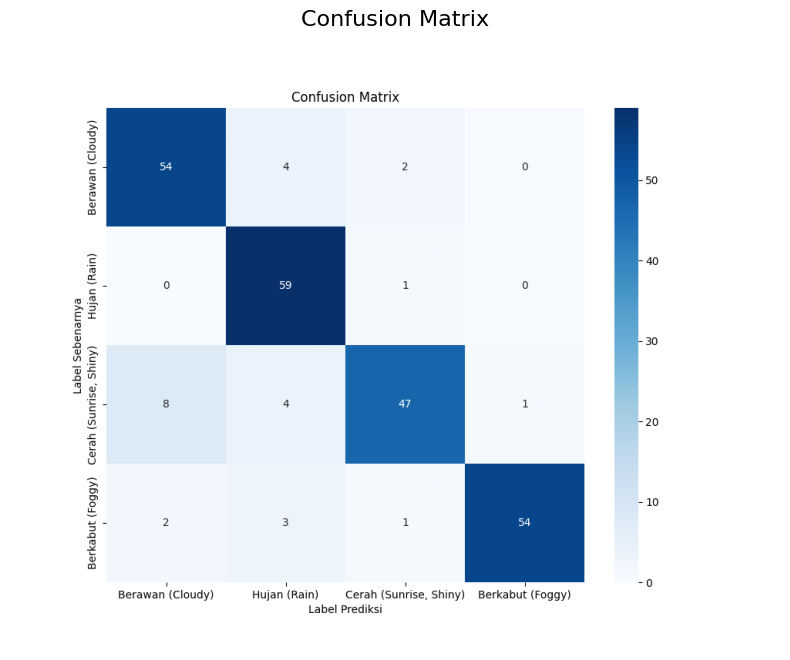

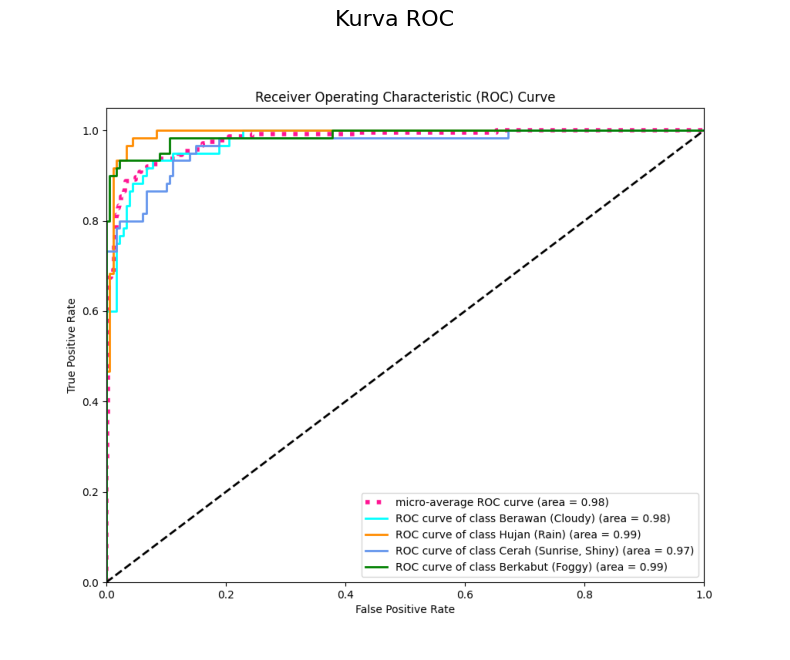

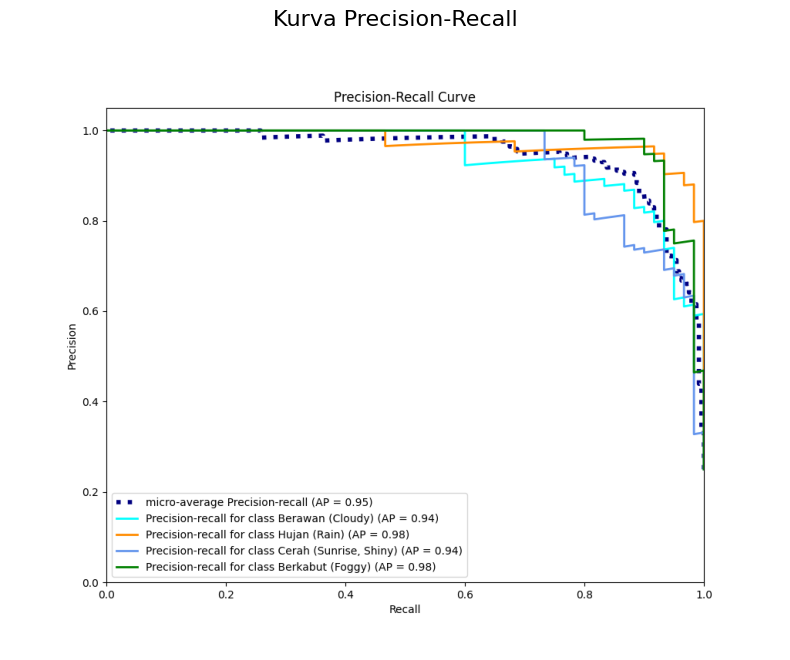

In [6]:
def display_image(path, title):
    try:
        img = mpimg.imread(path)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)
        plt.title(title, fontsize=16)
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"File tidak ditemukan di: {path}")

display_image(os.path.join(RESULTS_PATH, 'confusion_matrix.png'), 'Confusion Matrix')
display_image(os.path.join(RESULTS_PATH, 'roc_curve.png'), 'Kurva ROC')
display_image(os.path.join(RESULTS_PATH, 'precision_recall_curve.png'), 'Kurva Precision-Recall')

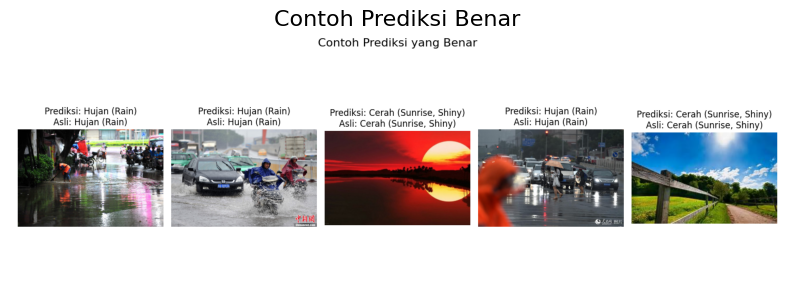

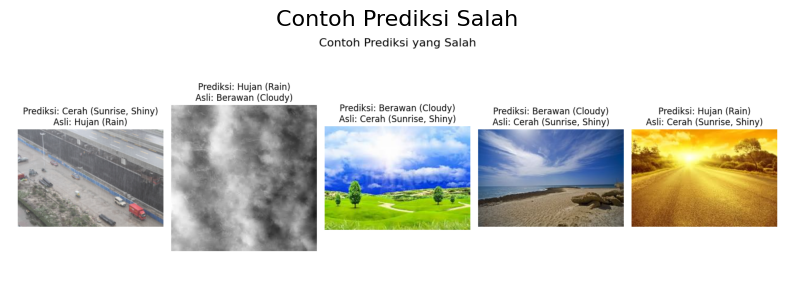

In [7]:
display_image(os.path.join(RESULTS_PATH, 'correct_predictions.png'), 'Contoh Prediksi Benar')
display_image(os.path.join(RESULTS_PATH, 'incorrect_predictions.png'), 'Contoh Prediksi Salah')